In [1]:
!pip install vncorenlp


# Chuẩn bị dữ liệu

In [2]:
import os
import urllib.request
import zipfile
import numpy as np
from tqdm import tqdm

# Tạo thư mục vncorenlp nếu chưa tồn tại
if not os.path.exists('vncorenlp'):
    os.makedirs('vncorenlp')

# Tải xuống tệp ZIP chứa VnCoreNLP
url = 'https://github.com/vncorenlp/VnCoreNLP/archive/refs/tags/v1.1.1.zip'
zip_path = 'vncorenlp/vncorenlp.zip'
urllib.request.urlretrieve(url, zip_path)

# Giải nén tệp ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('vncorenlp')

# Di chuyển tệp JAR và thư mục models vào thư mục vncorenlp
os.rename('vncorenlp/VnCoreNLP-1.1.1/VnCoreNLP-1.1.1.jar', 'vncorenlp/VnCoreNLP-1.1.1.jar')
os.rename('vncorenlp/VnCoreNLP-1.1.1/models', 'vncorenlp/models')


In [3]:
from vncorenlp import VnCoreNLP

# Đường dẫn đến tệp JAR
jar_path = 'vncorenlp/VnCoreNLP-1.1.1.jar'

# Khởi tạo VnCoreNLP với annotator là word segmentation (wseg)
rdrsegmenter = VnCoreNLP(jar_path, annotators="wseg", max_heap_size='-Xmx500m')


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("toreleon/synthetic-vietnamese-students-feedback-corpus")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/synthetic-vietnamese-students-feedback-corpus


In [5]:
import os
import pandas as pd

# List các file trong thư mục
print("Các file có trong thư mục dữ liệu:")
print(os.listdir(path))

# Đọc file train (giả sử tên file là synthetic_train.csv, bạn đổi tên nếu khác)
train_file = os.path.join(path, "synthetic_train.csv")
train_df = pd.read_csv(train_file)

# Hiển thị 5 dòng đầu
print(train_df.head())

Các file có trong thư mục dữ liệu:
['synthetic_val.csv', 'synthetic_train.csv']
                                            sentence sentiment       topic
0  Đội ngũ bảo trì quá thưa thớt dẫn đến không đả...  negative    facility
1  The university's musical and artistic faciliti...   neutral    facility
2  Phương pháp giảng dạy phù hợp với các đối tượn...   neutral  curriculum
3  Chương trình học giúp tôi trở thành một chuyên...  positive  curriculum
4  Tôi nghĩ rằng chương trình đào tạo có thể có t...   neutral  curriculum


# Bài 1: (2 điểm) 
### Sử dụng bộ ngữ liệu UIT-VSFC với bài toán phân loại cảm xúc dựa trên phản hồi của sinh viên, thực hiện phân đoạn từ (Word Segmentation) bằng công cụ VnCoreNLP. 

In [6]:
def word_segment(sentence):
    result = rdrsegmenter.annotate(sentence)
    words = [token['form'] for sent in result['sentences'] for token in sent]
    segmented = " ".join(words)
    return segmented


In [7]:
train_df['segmented_sentence'] = train_df['sentence'].apply(word_segment)
train_df.head()


,sentence,sentiment,topic,segmented_sentence
0,Đội ngũ bảo trì quá thưa thớt dẫn đến không đả...,negative,facility,Đội_ngũ bảo_trì quá thưa_thớt dẫn đến không đả...
1,The university's musical and artistic faciliti...,neutral,facility,The university ' s musical and artistic facili...
2,Phương pháp giảng dạy phù hợp với các đối tượn...,neutral,curriculum,Phương_pháp giảng_dạy phù_hợp với các đối_tượn...
3,Chương trình học giúp tôi trở thành một chuyên...,positive,curriculum,Chương_trình học giúp tôi trở_thành một chuyên...
4,Tôi nghĩ rằng chương trình đào tạo có thể có t...,neutral,curriculum,Tôi nghĩ rằng chương_trình đào_tạo có_thể có t...


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Tải model và tokenizer của PhoBERT
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
phobert_model = AutoModel.from_pretrained("vinai/phobert-base")

phobert_model.eval()  
phobert_model.to('cpu')  

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

# Bài 2: (2 điểm) 
### Sử dụng PhoBERT để trích xuất vector ngữ nghĩa của các câu phản hồi (sau khi đã được phân đoạn từ). 

In [12]:
# Hàm lấy vector mean pooling cho batch câu
def extract_phobert_vectors_batch(sentences, batch_size=32, device='cpu'):
    vectors = []
    with torch.no_grad():
        for i in tqdm(range(0, len(sentences), batch_size), dynamic_ncols=True, leave=True):
            batch_sentences = sentences[i:i+batch_size]
            # Tokenize và chuyển thành tensor
            encoded = phobert_tokenizer(batch_sentences, padding=True, truncation=True, return_tensors='pt')
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)

            outputs = phobert_model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_states = outputs.last_hidden_state  # shape: (batch_size, seq_len, hidden_dim)

            # Mean pooling (chỉ tính các token không bị padding)
            mask = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
            summed = torch.sum(last_hidden_states * mask, 1)
            counts = torch.clamp(mask.sum(1), min=1e-9)
            mean_pooled = summed / counts  # shape: (batch_size, hidden_dim)

            vectors.extend(mean_pooled.cpu().numpy())
    return np.array(vectors)


In [ ]:
sentences = train_df['segmented_sentence'].tolist()
phobert_vectors = extract_phobert_vectors_batch(sentences, batch_size=32)

# Gắn vector vào DataFrame (mỗi vector là 768 chiều)
train_df['phobert_vector'] = list(phobert_vectors)

100%|██████████| 255/255 [10:33<00:00,  2.49s/it]


In [14]:
train_df.head()

,sentence,sentiment,topic,segmented_sentence,phobert_vector
0,Đội ngũ bảo trì quá thưa thớt dẫn đến không đả...,negative,facility,Đội_ngũ bảo_trì quá thưa_thớt dẫn đến không đả...,"[0.04986526, 0.017853348, -0.17064674, -0.1937..."
1,The university's musical and artistic faciliti...,neutral,facility,The university ' s musical and artistic facili...,"[0.009991944, -0.030136306, -0.46139327, 0.052..."
2,Phương pháp giảng dạy phù hợp với các đối tượn...,neutral,curriculum,Phương_pháp giảng_dạy phù_hợp với các đối_tượn...,"[-0.09758855, -0.20305796, -0.15290904, -0.389..."
3,Chương trình học giúp tôi trở thành một chuyên...,positive,curriculum,Chương_trình học giúp tôi trở_thành một chuyên...,"[-0.026819304, -0.11227026, -0.15387695, -0.32..."
4,Tôi nghĩ rằng chương trình đào tạo có thể có t...,neutral,curriculum,Tôi nghĩ rằng chương_trình đào_tạo có_thể có t...,"[0.078407176, -0.03759175, -0.14593443, -0.059..."


# Bài 3: (6 điểm) 
### Sử dụng mô hình Gaussian Mixture xây dựng 3 clusters cho 3 nhãn Positive, Neutral, và Negative với phương pháp tối ưu Expectation Maximization (EM). Đánh giá kết quả của mô hình trên tập test sử dụng độ đo Precision, Recall, và F1. 

In [ ]:
import numpy as np
from tqdm import trange

class GaussianMixtureModel_normal:
    def __init__(self, n_components=3, max_iter=100, tol=1e-4):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def init_params(self, X):
        N, d = X.shape
        np.random.seed(42)
        self.mu = X[np.random.choice(N, self.n_components, replace=False)]
        self.sigma = np.array([np.eye(d) for _ in range(self.n_components)])
        self.pi = np.ones(self.n_components) / self.n_components

    def log_multivariate_gaussian(self, X, mean, cov):
        """Tính log xác suất phân phối chuẩn đa biến để tránh overflow"""
        d = X.shape[1]
        cov_det = np.linalg.det(cov) + 1e-8
        cov_inv = np.linalg.inv(cov + 1e-6 * np.eye(d))
        X_centered = X - mean
        exponent = np.einsum('ij,jk,ik->i', X_centered, cov_inv, X_centered)
        log_prob = -0.5 * (d * np.log(2 * np.pi) + np.log(cov_det) + exponent)
        return log_prob

    def e_step(self, X):
        N = X.shape[0]
        log_gamma = np.zeros((N, self.n_components))

        for k in range(self.n_components):
            log_prob = self.log_multivariate_gaussian(X, self.mu[k], self.sigma[k])
            log_gamma[:, k] = np.log(self.pi[k] + 1e-8) + log_prob

        # Chuẩn hóa bằng log-sum-exp trick
        max_log = np.max(log_gamma, axis=1, keepdims=True)
        log_gamma -= max_log  # để tránh overflow khi exp
        gamma = np.exp(log_gamma)
        gamma /= np.sum(gamma, axis=1, keepdims=True)
        return gamma

    def m_step(self, X, gamma):
        N, d = X.shape
        N_k = np.sum(gamma, axis=0)

        for k in range(self.n_components):
            if N_k[k] < 1e-6:
                self.mu[k] = X[np.random.choice(N)]
                self.sigma[k] = np.eye(d)
                self.pi[k] = 1.0 / self.n_components
            else:
                self.mu[k] = (gamma[:, k].T @ X) / (N_k[k] + 1e-8)
                X_centered = X - self.mu[k]
                gamma_k = gamma[:, k][:, np.newaxis]
                self.sigma[k] = (gamma_k * X_centered).T @ X_centered / (N_k[k] + 1e-8)
                self.sigma[k] += 1e-6 * np.eye(d)

        self.pi = N_k / (np.sum(N_k) + 1e-8)

    def compute_log_likelihood(self, X):
        N = X.shape[0]
        log_likelihoods = []

        for k in range(self.n_components):
            log_prob = self.log_multivariate_gaussian(X, self.mu[k], self.sigma[k])
            log_likelihoods.append(np.log(self.pi[k] + 1e-8) + log_prob)

        log_likelihoods = np.stack(log_likelihoods, axis=1)
        max_log = np.max(log_likelihoods, axis=1, keepdims=True)
        log_likelihoods -= max_log
        total = np.exp(log_likelihoods)
        return np.sum(max_log + np.log(np.sum(total, axis=1, keepdims=True) + 1e-8))

    def fit(self, X):
        self.init_params(X)
        prev_ll = None

        for i in trange(self.max_iter, desc="Training GMM"):
            gamma = self.e_step(X)
            self.m_step(X, gamma)
            log_likelihood = self.compute_log_likelihood(X)

            if prev_ll is not None and np.abs(log_likelihood - prev_ll) < self.tol:
                break
            prev_ll = log_likelihood

    def predict(self, X):
        gamma = self.e_step(X)
        return np.argmax(gamma, axis=1)

    def map_clusters_to_labels(self, y_true, y_pred_cluster):
        labels = np.unique(y_true)
        n_labels = len(labels)
        cost_matrix = np.zeros((self.n_components, n_labels), dtype=int)

        for i in range(self.n_components):
            for j in range(n_labels):
                cost_matrix[i, j] = -np.sum((y_pred_cluster == i) & (y_true == labels[j]))

        # Greedy mapping
        row_ind, col_ind = [], []
        used_cols = set()
        for i in range(self.n_components):
            best_j = np.argmin(cost_matrix[i])
            while best_j in used_cols:
                cost_matrix[i, best_j] = np.inf
                best_j = np.argmin(cost_matrix[i])
            row_ind.append(i)
            col_ind.append(best_j)
            used_cols.add(best_j)

        mapping = {row: labels[col] for row, col in zip(row_ind, col_ind)}
        return np.array([mapping[c] for c in y_pred_cluster])

    def evaluate(self, y_true, y_pred_cluster):
        y_pred = self.map_clusters_to_labels(y_true, y_pred_cluster)
        classes = np.unique(y_true)
        precision_list, recall_list, f1_list = [], [], []

        for c in classes:
            tp = np.sum((y_pred == c) & (y_true == c))
            fp = np.sum((y_pred == c) & (y_true != c))
            fn = np.sum((y_pred != c) & (y_true == c))

            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)
            f1 = 2 * precision * recall / (precision + recall + 1e-8)

            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

        return np.mean(precision_list), np.mean(recall_list), np.mean(f1_list)


#### Đoạn mã trên sử dụng lý thuyết Gaussion Mixture với kĩ thuật EM thông thường không thêm tối ưu hóa. Và vì đoạn mã có thời gian chạy ước tính quá lâu (khoảng tâm 3 tiếng) nên em quyết định thêm một vài kĩ thuật để tối ưu hóa thời gian chạy mặc dù nó đem lại một vài nhầm lẫn ảnh hưởng đến kết quả đánh giá về các độ đo theo yêu cầu.
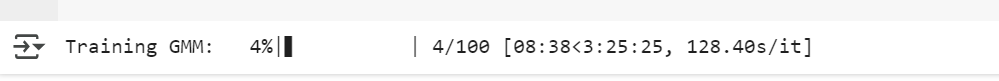

In [16]:
import numpy as np
from collections import Counter

class GaussianMixtureModel:
    def __init__(self, n_components=3, max_iter=100, tol=1e-4):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def init_params(self, X):
        n_samples, n_features = X.shape
        self.mu = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.var = np.ones((self.n_components, n_features)) * np.var(X, axis=0)
        self.pi = np.ones(self.n_components) / self.n_components

    def multivariate_gaussian(self, X, mean, var):
        eps = 1e-6
        var = np.clip(var, eps, 1e3)  # Tránh quá nhỏ hoặc quá lớn
        d = X.shape[1]
        log_coeff = -0.5 * np.sum(np.log(2 * np.pi * var))
        exp_term = -0.5 * np.sum(((X - mean) ** 2) / var, axis=1)
        log_prob = log_coeff + exp_term
        return log_prob  # trả về log probability để xử lý số học ổn định

    def e_step(self, X):
        n_samples = X.shape[0]
        log_resp = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            log_prob = self.multivariate_gaussian(X, self.mu[k], self.var[k])
            log_resp[:, k] = np.log(self.pi[k] + 1e-10) + log_prob
        # log-sum-exp trick để chuẩn hóa
        max_log_resp = np.max(log_resp, axis=1, keepdims=True)
        log_resp -= max_log_resp
        resp = np.exp(log_resp)
        resp /= np.sum(resp, axis=1, keepdims=True)
        return resp

    def m_step(self, X, gamma):
        n_samples, n_features = X.shape
        N_k = np.sum(gamma, axis=0) + 1e-10  # tránh chia 0

        self.mu = (gamma.T @ X) / N_k[:, None]
        self.var = np.zeros((self.n_components, n_features))
        for k in range(self.n_components):
            diff = X - self.mu[k]
            self.var[k] = np.sum(gamma[:, k][:, None] * (diff ** 2), axis=0) / N_k[k]
        # Clip variance để ổn định
        self.var = np.clip(self.var, 1e-6, 1e3)
        self.pi = N_k / n_samples

    def compute_lower_bound(self, X, gamma):
        """Tính log-likelihood cho kiểm tra hội tụ"""
        n_samples = X.shape[0]
        log_likelihood = 0
        for k in range(self.n_components):
            log_prob = self.multivariate_gaussian(X, self.mu[k], self.var[k])
            log_likelihood += np.sum(gamma[:, k] * (np.log(self.pi[k] + 1e-10) + log_prob - np.log(gamma[:, k] + 1e-10)))
        return log_likelihood

    def fit(self, X):
        self.init_params(X)
        prev_lower_bound = None

        for i in range(self.max_iter):
            gamma = self.e_step(X)
            self.m_step(X, gamma)

            lower_bound = self.compute_lower_bound(X, gamma)
            if prev_lower_bound is not None and abs(lower_bound - prev_lower_bound) < self.tol:
                print(f"Converged at iteration {i+1}")
                break
            prev_lower_bound = lower_bound

            # In tiến trình đơn giản
            if (i+1) % max(1, self.max_iter//20) == 0 or i == 0:
                print(f"Iteration {i+1}/{self.max_iter} - Lower bound: {lower_bound:.4f}")

    def predict(self, X):
        gamma = self.e_step(X)
        return np.argmax(gamma, axis=1)

    def map_clusters_to_labels(self, y_true, y_pred_cluster):
        # Ánh xạ nhãn cluster sang nhãn thực để tính metric
        from scipy.optimize import linear_sum_assignment
        labels = np.unique(y_true)
        cost_matrix = np.zeros((self.n_components, len(labels)), dtype=int)
        for i in range(self.n_components):
            for j, label in enumerate(labels):
                cost_matrix[i, j] = -np.sum((y_pred_cluster == i) & (y_true == label))
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        mapping = {row: labels[col] for row, col in zip(row_ind, col_ind)}
        return np.array([mapping[c] for c in y_pred_cluster])

    def evaluate(self, y_true, y_pred_cluster):
        y_pred = self.map_clusters_to_labels(y_true, y_pred_cluster)
        classes = np.unique(y_true)
        precision_list, recall_list, f1_list = [], [], []
        for c in classes:
            tp = np.sum((y_pred == c) & (y_true == c))
            fp = np.sum((y_pred == c) & (y_true != c))
            fn = np.sum((y_pred != c) & (y_true == c))
            precision = tp / (tp + fp + 1e-10)
            recall = tp / (tp + fn + 1e-10)
            f1 = 2 * precision * recall / (precision + recall + 1e-10)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
        return np.mean(precision_list), np.mean(recall_list), np.mean(f1_list)


#### Các bước thêm vào để tối ưu thời gian chạy
1. Khởi tạo tham số ngẫu nhiên có kiểm soát
- Code: self.mu = X[np.random.choice(n_samples, self.n_components, replace=False)]
- Tác dụng: Thay vì khởi tạo ngẫu nhiên hoàn toàn (có thể lặp lại điểm), đoạn này chọn các điểm khác nhau trong tập dữ liệu ban đầu, tránh trùng lặp.
2. Log-space computation (xử lý trong không gian log)
- Code: log_prob, log_resp, log_coeff, ...
- Tác dụng: Để tránh hiện tượng underflow khi nhân nhiều xác suất nhỏ, bạn dùng log-probability thay vì xác suất gốc → ổn định số học hơn.
3. Log-Sum-Exp trick
- Code:
max_log_resp = np.max(log_resp, axis=1, keepdims=True)
log_resp -= max_log_resp
resp = np.exp(log_resp)
-Tác dụng: Giúp chuẩn hóa phân phối softmax trong không gian log để tránh overflow/underflow và cải thiện độ ổn định số học.
4. Thêm epsilon để tránh chia cho 0 hoặc log(0)
- Code: +1e-10, np.clip(..., 1e-6, 1e3)
- Tác dụng: Tránh các lỗi chia cho 0 và log(0), đồng thời giới hạn phương sai quá nhỏ hoặc quá lớn để giữ tính ổn định.
5. Cắt ngưỡng phương sai (variance clipping)
- Code: np.clip(self.var, 1e-6, 1e3)
- Tác dụng: Đảm bảo không có phương sai nào gần 0 hoặc quá lớn gây lỗi số học, giữ mô hình không bị tràn hoặc co cụm sai.
6. Dừng sớm (early stopping) dựa trên log-likelihood
- Code: if abs(lower_bound - prev_lower_bound) < self.tol
- Tác dụng: Dừng thuật toán nếu log-likelihood hội tụ, tránh lặp không cần thiết.
7. Giới hạn số vòng lặp max_iter
- Code: for i in range(self.max_iter)
- Tác dụng: Dù hội tụ chưa đạt, thuật toán vẫn dừng để tránh chạy mãi → kiểm soát chi phí tính toán.
8. In tiến trình huấn luyện theo batch
- Code: if (i+1) % max(1, self.max_iter//20) == 0 or i == 0
- Tác dụng: Gợi ý theo dõi sự thay đổi log-likelihood từng vài vòng → giúp theo dõi độ hội tụ.
9. Ánh xạ cluster về nhãn thật bằng giải bài toán phân công (Hungarian algorithm)
- Code: linear_sum_assignment(cost_matrix)
- Tác dụng: Dùng hàm tối ưu để ánh xạ nhãn cluster với nhãn thật cho đánh giá chính xác Precision/Recall/F1.


In [17]:
test_file = os.path.join(path, "synthetic_val.csv")
test_df = pd.read_csv(test_file)

In [18]:
test_df['segmented_sentence'] = test_df['sentence'].apply(word_segment)


In [ ]:
sentences = test_df['segmented_sentence'].tolist()
phobert_vectors = extract_phobert_vectors_batch(sentences, batch_size=32)

# Gắn vector vào DataFrame (mỗi vector là 768 chiều)
test_df['phobert_vector'] = list(phobert_vectors)


100%|██████████| 64/64 [02:44<00:00,  2.58s/it]


In [20]:
train_df.to_pickle("train_df.pkl")
print("Saved train_df to train_df.pkl")
test_df.to_pickle("test_df.pkl")
print("Saved test_df to test_df.pkl")

Saved train_df to train_df.pkl
Saved test_df to test_df.pkl


In [21]:
import pandas as pd
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

In [22]:
# Tạo tập train phù hợp
X_train = np.array(train_df["phobert_vector"].tolist())  # Danh sách các vector → numpy array
y_train = train_df["sentiment"].map({"positive": 0, "neutral": 1, "negative": 2}).values

#Tạo tập test phù hợp
X_test = np.array(test_df["phobert_vector"].tolist())
y_test = test_df["sentiment"].map({"positive": 0, "neutral": 1, "negative": 2}).values


In [23]:
train_df.head()

,sentence,sentiment,topic,segmented_sentence,phobert_vector
0,Đội ngũ bảo trì quá thưa thớt dẫn đến không đả...,negative,facility,Đội_ngũ bảo_trì quá thưa_thớt dẫn đến không đả...,"[0.04986526, 0.017853348, -0.17064674, -0.1937..."
1,The university's musical and artistic faciliti...,neutral,facility,The university ' s musical and artistic facili...,"[0.009991944, -0.030136306, -0.46139327, 0.052..."
2,Phương pháp giảng dạy phù hợp với các đối tượn...,neutral,curriculum,Phương_pháp giảng_dạy phù_hợp với các đối_tượn...,"[-0.09758855, -0.20305796, -0.15290904, -0.389..."
3,Chương trình học giúp tôi trở thành một chuyên...,positive,curriculum,Chương_trình học giúp tôi trở_thành một chuyên...,"[-0.026819304, -0.11227026, -0.15387695, -0.32..."
4,Tôi nghĩ rằng chương trình đào tạo có thể có t...,neutral,curriculum,Tôi nghĩ rằng chương_trình đào_tạo có_thể có t...,"[0.078407176, -0.03759175, -0.14593443, -0.059..."


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)


In [25]:
# 1. Huấn luyện trên tập train
model = GaussianMixtureModel(n_components=3)
model.fit(X_train)

# 2. Predict cluster cho tập test
y_cluster_test = model.predict(X_test)

# 3. Gán cluster → nhãn bằng mapping từ tập train
y_cluster_train = model.predict(X_train)
mapping = model.map_clusters_to_labels(y_train, y_cluster_train)
# Áp mapping cho cluster của test
y_test_pred = np.array([mapping[c] for c in y_cluster_test])

# 4. Đánh giá tập test
precision, recall, f1 = model.evaluate(y_test, y_test_pred)
print("Test Precision:", round(precision, 4))
print("Test Recall:", round(recall, 4))
print("Test F1 Score:", round(f1, 4))


Iteration 1/100 - Lower bound: -8647976.9609
Iteration 5/100 - Lower bound: -8500036.6280
Iteration 10/100 - Lower bound: -8476919.9265
Iteration 15/100 - Lower bound: -8473292.7117
Iteration 20/100 - Lower bound: -8472610.2466
Iteration 25/100 - Lower bound: -8472531.7054
Iteration 30/100 - Lower bound: -8472511.0537
Iteration 35/100 - Lower bound: -8472503.9834
Iteration 40/100 - Lower bound: -8472495.8955
Iteration 45/100 - Lower bound: -8472482.2402
Iteration 50/100 - Lower bound: -8472454.3666
Iteration 55/100 - Lower bound: -8472448.2941
Iteration 60/100 - Lower bound: -8472446.8810
Iteration 65/100 - Lower bound: -8472446.7480
Iteration 70/100 - Lower bound: -8472446.7329
Iteration 75/100 - Lower bound: -8472446.7310
Converged at iteration 76
Test Precision: 0.2922
Test Recall: 0.4268
Test F1 Score: 0.3435


Chuẩn hóa dữ liệu cho ra F1 Score cao hơn khi không chuẩn hóa mặc dù Precision thấp hơn.